# time dynamics stats

In [73]:
import numpy as np
import pandas as pd
# %matplotlib widget
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d.art3d import Poly3DCollection
import matplotlib.cm as cm
from matplotlib.animation import FuncAnimation
import itertools
import random
import seaborn as sns
import os
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
from src.d03_processing.fixations.SignalProcessor import SignalProcessor

In [120]:
df = pd.read_csv('proportion_time_dynamics.csv')
df = df[df.time > 1000].drop('Unnamed: 0', axis=1).reset_index(drop=True)
df['table_minus_selected'] = df['table'] - df['selected']
df['table_minus_moved'] = df['table'] - df['moved']
df['moved_minus_selected'] = df['moved'] - df['selected']

Older
Younger


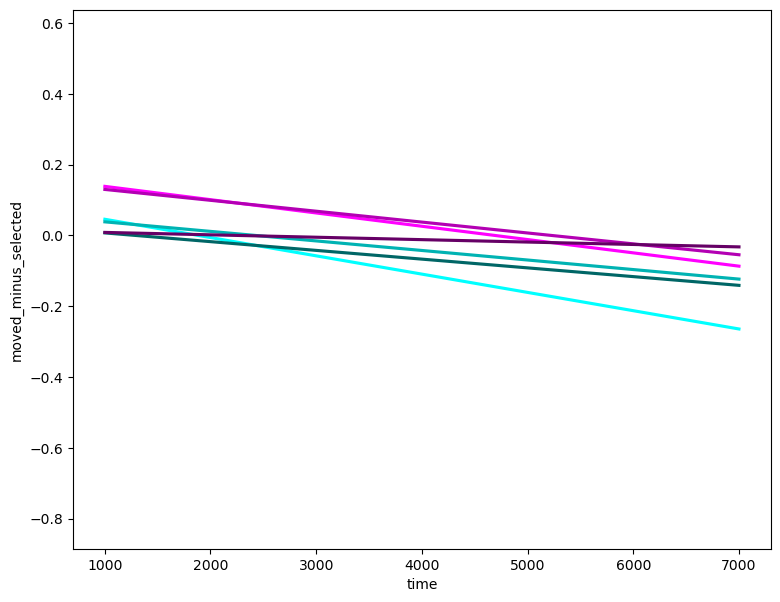

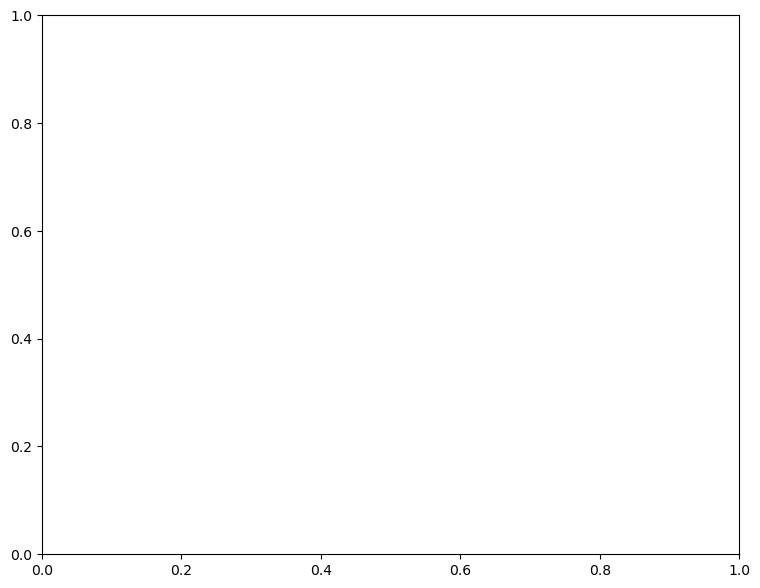

In [129]:
# ax = plt.figure(figsize=(9, 7)).add_subplot()
# sns.scatterplot(x='time', y='table', data=df, hue='group', ax=ax, palette="Set2", alpha=0.1, size=0.1)
# plt.show()
aois_plot= ['moved', 'selected', 'table']
colours = ['r', 'g', 'b', (0, 1, 1), (1, 0, 1)]
colours2 = [(1, 0.5, 0), (0.1, 1, 0.2), (0, 0.5, 1), (0, 0.7, 0.7), (0.7, 0.0, 0.7)]
colours3 = [(1, 0.5, 0), (0.1, 1, 0.2), (0, 0.5, 1), (0, 0.4, 0.4), (0.4, 0.0, 0.4)]
aoi_col = 'table_minus_selected'
aoi_col2 = 'table_minus_moved'
aoi_col3 = 'moved_minus_selected'
ax = plt.figure(figsize=(9, 7)).add_subplot()
ax2 = plt.figure(figsize=(9, 7)).add_subplot()
g_ind = [3, 4]
p_ind=[i for i in range(2)]
p_ind = []
for g, group in enumerate(np.unique(df.group)):
    if g in g_ind:
        print(group)
        df_g = df[df.group == group]
        # sns.regplot(data=df_g, x='time', y=aoi_col, ax=ax, scatter_kws=dict(alpha=0.0, color=colours[g]), line_kws=dict(color=colours[g], alpha=1))
        # sns.regplot(data=df_g, x='time', y=aoi_col2, ax=ax, scatter_kws=dict(alpha=0.0, color=colours2[g]), line_kws=dict(color=colours2[g], alpha=1))
        # sns.regplot(data=df_g, x='time', y=aoi_col3, ax=ax, scatter_kws=dict(alpha=0.0, color=colours3[g]), line_kws=dict(color=colours3[g], alpha=1))
        for p, ppt in enumerate(np.unique(df_g.participant)):
            if p in p_ind:
                df_p = df_g[df_g.participant == ppt]
                # sns.regplot(data=df_p, x='time', y=aoi_col, ax=ax, scatter_kws=dict(alpha=0.01, color=colours[0]), line_kws=dict(color=colours[0], alpha=1))
                # # sns.regplot(data=df_p, x='time', y='ma', ax=ax, scatter_kws=dict(alpha=0.01, color=colours[g]), line_kws=dict(color=colours[g], alpha=1))
                # sns.regplot(data=df_p, x='time', y=aoi_col2, ax=ax, scatter_kws=dict(alpha=0.01, color=colours2[1]), line_kws=dict(color=colours2[1], alpha=1))
                # sns.regplot(data=df_p, x='time', y=aoi_col3, ax=ax, scatter_kws=dict(alpha=0.01, color=colours2[2]), line_kws=dict(color=colours2[2], alpha=1))




# sns.lmplot(x='time', y='table', data=df_1, hue='group', palette="Set2", legend=False, aspect =1.3, scatter_kws=dict(alpha=0.0) )
plt.show()